## Homework 7

## <em> VI, EL$_2$O, Generative Models, Multimodal Posteriors, and Bayesian Evidence</em>
<br>
This notebook is arranged in cells. Texts are usually written in the markdown cells, and here you can use html tags (make it bold, italic, colored, etc). You can double click on this cell to see the formatting.<br>
<br>
The ellipsis (...) are provided where you are expected to write your solution but feel free to change the template (not over much) in case this style is not to your taste. <br>
<br>
<em>Hit "Shift-Enter" on a code cell to evaluate it.  Double click a Markdown cell to edit. </em><br>


***

### Imports

In [1]:
import os
%pylab inline
import pickle
!pip install corner
import corner
import time
PROJECT_PATH = os.path.abspath('/content/drive/My Drive/P188_288/P188_288_HW7/')
!pip install tensorflow==1.15.0
!pip install tensorflow_probability==0.7.0
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.contrib.distributions import softplus_inverse

Populating the interactive namespace from numpy and matplotlib
     |████████████████████████████████| 412.3 MB 20 kB/s 
     |████████████████████████████████| 50 kB 6.7 MB/s 
     |████████████████████████████████| 503 kB 57.9 MB/s 
     |████████████████████████████████| 3.8 MB 42.0 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=f1fa4cd454e2fb5c49007a7ee4fd4f9fb4d60fb579b614211bb45ac45062277e
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: gast
    Found existing ins

### Mounting Google Drive locally
Mount your Google Drive on your runtime using an authorization code.

Note: When using the 'Mount Drive' button in the file browser, no authentication codes are necessary for notebooks that have only been edited by the current user.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***

#### Problem 1 - Image reconstruction from noisy and incomplete images

This exercise is based on https://arxiv.org/pdf/1910.10046.pdf:

Data reconstruction from corrupted data lies at the heart of Bayesian inverse problems. There are many ways in which data can be corrupted, ranging from missing data (or masking) to noise and blurring. In many cases the reconstructed data, e.g. an image, is high dimensional. Data reconstruction commonly faces two challenges: 1) For most data it is difficult to find a prior that optimally represents our knowledge of the uncorrupted data. Instead, priors are often chosen to impose certain regularity conditions (e.g. maximum entropy, smoothness). 2) While it is usually tractable to find the maximum of the posterior, i.e. the most probable underlying realization, a full uncertainty quantification of the reconstruction is usually prohibitively expensive.

We address these challenges with generative models, which provide a mapping from points in a typically lower dimensional latent space to points in the high dimensional data space. As an example of such a model we will be using a Variational AutoEncoder (VAE). 

VAEs are designed to model the distribution $p_{\phi}(\textbf{x})$ of high-dimensional input data, $\textbf{x}$, by introducing a mapping $p_{\phi}(\textbf{x}|\textbf{z})$ to a lower dimensional latent representation, $\textbf{z}$. The latent space variables are enforced to follow a given prior distribution, $p(\textbf{z})$, which is typically chosen to be a standard normal distribution.

Given a generative model, the posterior of the latent variables for a given data realization can be modeled with Bayes rule
$$ p_{\phi}(\textbf{z}|\textbf{x}) \propto p_{\phi}(\textbf{x}|\textbf{z})p(\textbf{z}) $$

This formulation allows to address both aforementioned problems: 1) The prior distribution, p(z), reflects the distribution of the training data. 2) The representation of the posterior in the lower dimensional latent space enables tractable posterior analysis. In particular it allows to examine and fit the posterior distribution and draw samples from it. The samples can then be visualized in data space by forward modeling with the generative model.

In this exercise, consider examples of data corruption on the MNIST dataset. First, load the MNIST dataset.

In [3]:
# functions to load mnist dataset
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test
  
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

Then, let's create a corrupted image. Here, we mask half of the image and add noise with to the other half.

In [4]:
data_dim    = 28*28 # data dimensionality
data_size   = 1     # number of corrupted input data, always 1
sigma_n     = 0.1   # noise level used in the likelihood, determined during VAE training or measured
hidden_size = 10    # latent space dimensionality of the VAE
sample_size = 512   # number of samples drawn in each step of the ELBO minimization (for stochastic VI only)
n_channels  = 1     # mnist is b/w -> 1 channel
seed        = 777   # random seed

### choose one of the following to run different examples

# settings for reconstruction with noise and mask
corr_type   = 'noise+mask'
num_mnist   = 6
label       = 'masknoise05'
noise_level = 0.5
num_comp    = 3

PROJECT_PATH = os.path.abspath('/content/drive/My Drive/P188_288/P188_288_HW7/')
plot_path        = os.path.join(PROJECT_PATH,'plots/')

# Saving plots
plot_path = os.path.join(plot_path,'%s/'%label)

if not os.path.isdir(plot_path):
    os.makedirs(plot_path)
    
def plot_image(image, save=True, directory='./plots/',filename='plotted_image', title='image',vmin=None,vmax=None, mask=None):
    """
    plots and saves a single image of mnist format
    """

    if np.any(mask==None):
        mask=np.ones_like(image)
    mask = np.reshape(mask,(28,28))
    plt.figure()
    #plt.title(title)
    plt.imshow((image).reshape((28,28))*mask,cmap='gray',vmin=vmin, vmax=vmax)
    plt.axis('off')
    #plt.colorbar()
    if save: 
        plt.savefig(directory+filename+'.pdf',bbox_inches='tight')
    plt.show()

    return True

def get_custom_noise(shape, signal_dependent=False, signal =None, sigma_low=0.07, sigma_high=0.22, threshold=0.02 ):
    """
    adds the model error and the noise level in the data to obtain the total sigma that is used in the likelihood (option to make the reconstruction error signal dependent is not used) 
    """
    sigma = np.ones(shape)*sigma_n

    if signal_dependent: 
        for ii in range(data_size):
            sigma[ii][np.where(signal[ii]<=threshold)]= sigma_low
            sigma[ii][np.where(signal[ii]>threshold)]= sigma_high

    data_noise = np.ones_like(sigma)*noise_level

    sigma = np.sqrt(sigma**2+data_noise**2)

    return sigma
  

def make_corrupted_data(x_true, corr_type='mask'):
    """
    creates the corrupted image according to chosen corruption type
    """

    mask = np.ones((28,28))

    if corr_type=='mask':

        minx = 10
        maxx = 24

        mask[0:28,minx:maxx]=0.
        mask = mask.reshape((28*28))

        corr_data = x_true*[mask]

    elif corr_type=='sparse mask':

        mask    = np.ones(data_dim, dtype=int)
        percent = 95
        np.random.seed(seed+2)
        indices = np.random.choice(np.arange(data_dim), replace=False,size=int(percent/100.*data_dim))
        print('precentage masked:', len(indices)/data_dim)
        mask[indices] =0 

        corr_data = x_true*[mask]

    elif corr_type=='noise':

        np.random.seed(seed+2)
        noise = np.random.randn(data_dim*data_size)*noise_level

        corr_data = x_true+noise

    elif corr_type=='noise+mask':

        np.random.seed(seed+2)
        noise = np.random.randn(data_dim*data_size)*noise_level

        minx = 14
        maxx = 28

        mask[0:28,minx:maxx]=0.
        mask = mask.reshape((28*28))

        corr_data = x_true+noise
        corr_data = corr_data*[mask]

    elif corr_type=='none':

        corr_data = x_true

    corr_data = np.expand_dims(corr_data,-1)

    mask = mask.flatten()

    return corr_data, mask

Using a pre-defined function "plot_image," you can easily plot an image of MNIST datasets. Below we plot corrupted data and the underlying truth. Note that plots are saved in HW8/plots/ in your datahub directory.

Truth:


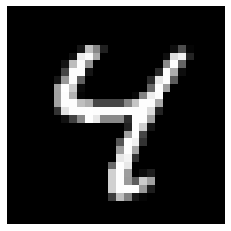

Data:


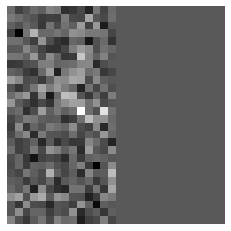

True

In [5]:
# create underlying truth
truth = x_test[num_mnist:num_mnist+data_size]
# create corrupted data
data, custom_mask = make_corrupted_data(truth, corr_type=corr_type)
# noise
noise = get_custom_noise(data.shape, signal_dependent=False, signal=truth)

# Make plot
print('Truth:')
plot_image(truth, directory=plot_path, filename='truth_%s'%label, title='truth')
print('Data:')
plot_image(data, directory=plot_path, filename='input_data_%s'%label, title='data')

We already trained a VAE on the uncorrupted training set with both encoder, $f_{\psi}$, and decoder, $g_{\phi}$, parameterized as a sequence of 4 fully-connected ResNet blocks, each block containing 2 fully-connected layers with size 512 and LeakyRelu activation. The encoder reduces the dimensionality to 10. We minimize the loss using ADAM with default parameters, a batch size of 1024, and a decreasing learning rate starting at 0.001. We only give you already trained generative models because creating such VAEs is beyond the scope of this course.

To ensure that the prior is well described by a unit variance Gaussian, we augment the forward model by a normalizing flow, using RealNVP. The normalizing flow is trained to map the latent space distribution of the VAE to a standard normal distribution.

A more detailed procedure is described below.
![alt text](https://drive.google.com/uc?id=1D0I_zLxYsNfybe0KiTN7oxEbDITTLyIt)
We train a vanilla VAE with Gaussian likelihood on uncorrupted training data.
![alt text](https://drive.google.com/uc?id=11l4zdFJjhlivPI_CtFufDOztoCHQQUCN)
Then, in a second step a bijective normalizing flow is fitted to map the distribution of the encoded training data to a normal distribution.

In [5]:
# pathes to trained generative models
generator_path   = os.path.join(PROJECT_PATH,'modules/decoder1/decoder')
encoder_path     = os.path.join(PROJECT_PATH,'modules/encoder1/encoder')
nvp_func_path    = os.path.join(PROJECT_PATH,'modules/nvp1/')
minima_path      = os.path.join(PROJECT_PATH,'minima/')

With the help of VAE and normalizing flow, we can do the posterior analysis in the latent space. We choose the dimension of the latent space to be 10 (set by "hidden_size" earlier). First, write a function for the log posterior:

In [6]:
def fwd_pass(generator,nvp,z,mask):
    """
    a pass through the forward model (nvp+VAE generator)
    """ 

    fwd_z           = nvp({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':z},as_dict=True)['fwd_pass']

    gen_z           = tf.boolean_mask(tf.reshape(generator(fwd_z),[data_size,data_dim,n_channels]),mask, axis=1)

    return gen_z


def get_likelihood(generator,nvp,z,sigma,mask):
    """
    compute the likelihood for a given latent space vector
    """
    gen_z           = fwd_pass(generator,nvp,z,mask)

    sigma           = tf.boolean_mask(sigma,mask, axis=1)

    likelihood      = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_z,scale_diag=sigma))

    return likelihood

def get_prior():
    """
    return the Gaussian prior
    """

    return tfd.MultivariateNormalDiag(tf.zeros([data_size,hidden_size]), scale_identity_multiplier=1.0, name ='prior')

def get_log_posterior(z,x,generator,nvp,sigma,mask, beta):
    """
    returns the negative log posterior (or rather joint dsitribution) - log(p(x,z)), where x is the corrupted input image 
    """

    likelihood      = get_likelihood(generator,nvp,z,sigma,mask)

    prior           = get_prior()

    masked_x        = tf.boolean_mask(x,mask, axis=1)

    log_posterior   = prior.log_prob(z)+likelihood.log_prob(masked_x)*beta

    return log_posterior


def get_recon(generator,nvp, z,sigma,mask):
    """
    forward models a given point in latent space to data space
    """

    prob = get_likelihood(generator,nvp, z,sigma,mask)

    recon= prob.mean()

    return recon

def get_hessian(func, z):
    """
    computes the hessian of function func at point z
    """

    hess             = tf.hessians(func,z)
    hess             = tf.gather(hess, 0)

    return(tf.reduce_sum(hess, axis = 2 ))


def get_GN_hessian(generator,nvp,z,mask,sigma):
    '''
    computes the Gauss Newton approximation to the Hessian
    '''

    gen_z            = fwd_pass(generator,nvp,z,mask)

    sigma            = tf.boolean_mask(sigma,mask, axis=1)

    grad_g           = tf.gather(tf.gradients(gen_z/(sigma),z),0)

    grad_g2          = tf.einsum('ij,ik->ijk',grad_g,grad_g)

    one              = tf.linalg.eye(hidden_size, batch_shape=[data_size],dtype=tf.float32)

    hess_GN          = one+grad_g2

    return hess_GN
  
def compute_covariance(hessian):
    """
    computes the covariance by inverting the hessian (symmetrization for numerical stability)
    """

    cov = tf.linalg.inv(hessian)

    cov = (cov+tf.linalg.transpose(cov))*0.5

    return cov

def get_random_start_values(num, my_sess):
    """
    returns random starting values drawn from the prior
    """
    result=[]
    for ii in range(num):
        result.append(my_sess.run(get_prior().sample()))
    return result

Next, we define variables and functions needed to perform the posterior analysis.

In [7]:
tf.reset_default_graph()

#### Variables ####
#noise level 
sigma_corr  = tf.placeholder_with_default(np.ones([data_size,data_dim,n_channels], dtype='float32')*sigma_n,shape=[data_size,data_dim,n_channels])
#mask
mask        = tf.placeholder_with_default(np.ones([data_dim], dtype='float32'),shape=[data_dim])
#corrupted input data
input_data  = tf.placeholder(shape=[data_size,data_dim,n_channels], dtype=tf.float32)
#temperature used for annealed minimzation
inverse_T   = tf.placeholder_with_default(1., shape=[])
#learning rate
lr          = tf.placeholder_with_default(0.001,shape=[])

#### Modules ####
generator   = hub.Module(generator_path, trainable=False)
nvp_funcs   = hub.Module(nvp_func_path, trainable=False)

In [8]:
#### for Maximum a Posteriori estimate ####
MAP_ini     = tf.placeholder_with_default(tf.zeros([data_size,hidden_size]),shape=[data_size,hidden_size])
MAP         = tf.Variable(MAP_ini)
MAP_reset   = tf.stop_gradient(MAP.assign(MAP_ini))

nlPost_MAP  = get_log_posterior(MAP, input_data, generator,nvp_funcs, sigma_corr,mask, inverse_T)
loss_MAP    = -tf.reduce_mean(nlPost_MAP)

optimizer   = tf.train.AdamOptimizer(learning_rate=lr)
opt_op_MAP  = optimizer.minimize(loss_MAP, var_list=[MAP])

recon_MAP   = get_recon(generator,nvp_funcs, MAP,sigma_corr,mask)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [9]:
##### for Laplace approximation around a point ####
hessian     = get_hessian(-nlPost_MAP,MAP)
GN_hessian  = get_GN_hessian(generator,nvp_funcs,MAP,mask,sigma_corr)
ini_val  = np.ones((data_size,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
with tf.variable_scope("Laplace_Posterior",reuse=tf.AUTO_REUSE):
    mu_new      = tf.Variable(np.ones((data_size,hidden_size),dtype=np.float32), dtype=np.float32)
    sigma_new_t = ini_val
    sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus),dtype=tf.float32)

approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)

update_mu          = mu_new.assign(MAP)
covariance         = compute_covariance(hessian)
variance           = tf.linalg.diag_part(covariance)[0]
update_TriL        = sigma_new_t2.assign(tf.linalg.cholesky(covariance))

posterior_sample   = approx_posterior_laplace.sample()

recon              = get_recon(generator,nvp_funcs, posterior_sample ,sigma_corr,mask)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [10]:
#for ELBO

########## Syochastic VI estimates by minimizing the elbo #############

def get_neg_elbo(x,approx_posterior, generator, nvp, sigma, mask):
    """
    computes the negative evidence lower bound (ELBO)
    """

    prior          = get_prior()
    kl_divergence  = tfd.kl_divergence(approx_posterior, prior) 

    z_sample       = tf.reshape(approx_posterior.sample(sample_size),[-1,hidden_size])

    fwd_z          = nvp({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':z_sample},as_dict=True)['fwd_pass']
    gen_z          = tf.boolean_mask(tf.reshape(generator(fwd_z),[sample_size,data_size,data_dim,n_channels]),mask, axis=2)
    sig            = tf.boolean_mask(sigma,mask, axis=1)

    likelihood     = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_z,scale_diag=sig))

    masked_x       = tf.boolean_mask(x, mask, axis=1)
    like_prob      = likelihood.log_prob(tf.expand_dims(masked_x,0))

    elbo           = tf.reduce_mean(like_prob)- kl_divergence

    return -elbo

def minimize_neg_elbo(x,custom_mask,noise,my_sess,full_rank=False):
    """
    function to run a ELBO minimzation for stochastic VI.
    """


    if full_rank:
        sets = zip([1e-3,1e-4,1e-6],[2000,500,300])
    else:
        sets = zip([1e-3,1e-4,1e-5],[2000,500,300])

    elbo_loss = []
    start = time.time()
    for lrate, numiter in sets:
        print('lrate', lrate)
        for jj in range(numiter):
            if full_rank:
                _, ll = my_sess.run([opt_op_elbo_fr,neg_elbo_fr],feed_dict={input_data: x, mask:custom_mask, sigma_corr:noise, lr: lrate})
            else:
                _, ll = my_sess.run([opt_op_elbo,neg_elbo],feed_dict={input_data: x, mask:custom_mask, sigma_corr:noise, lr: lrate})
            elbo_loss.append(ll)
            if jj%1000==0:
                print('iter', jj, 'loss', ll)
                #if full_rank:
                #  print(my_sess.run([mu_vi,post_vi.covariance()],feed_dict={input_data: x, mask:custom_mask, sigma_corr:noise, lr: lrate}))
    end= time.time()
    print('time taken',end-start)
    loss    = ll
    plt.figure()
    plt.plot(elbo_loss)
    plt.ylabel('loss')
    plt.xlabel('iteration')
    plt.show()

    return True
  
def add_small_offset(x):
    """offset added to the diagonal of the covariance, needed to make SVI stable"""
    return tf.add(x,1e-8)

#### mean field VI ####
with tf.variable_scope("posterior_elbo_mean",reuse=tf.AUTO_REUSE):
    mu_elbo      = tf.Variable(np.zeros((data_size,hidden_size)), dtype=np.float32)
    sigma_elbo   = tf.Variable(np.ones((data_size,hidden_size)), dtype=np.float32)

update_mu_elbo = tf.stop_gradient(mu_elbo.assign(MAP))

approx_posterior_elbo = tfd.MultivariateNormalDiag(loc=mu_elbo,scale_diag=sigma_elbo, name='approxposterior_elbo')

neg_elbo       = get_neg_elbo(input_data, approx_posterior_elbo, generator, nvp_funcs, sigma_corr, mask)
opt_op_elbo    = optimizer.minimize(neg_elbo,var_list=[mu_elbo,sigma_elbo])

nlPost_elbo    = -tf.reduce_mean(get_log_posterior(mu_elbo, input_data, generator,nvp_funcs, sigma_corr,mask, 1))
#######################


### full rank VI ###
ini_val1     = np.zeros((data_size,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
with tf.variable_scope("posterior_elbo_fullrank",reuse=tf.AUTO_REUSE):
    mu_vi      = tf.Variable(np.ones((data_size,hidden_size)), dtype=np.float32)
    sigma_vi   = tf.Variable(ini_val1)
sigma_vit    = tfd.matrix_diag_transform(tfd.fill_triangular(sigma_vi), transform=tf.nn.softplus)
sigma_vit    = tfd.matrix_diag_transform(sigma_vit, transform=add_small_offset)
post_vi      = tfd.MultivariateNormalTriL(loc=mu_vi,scale_tril=sigma_vit)

neg_elbo_fr    = get_neg_elbo(input_data, post_vi, generator, nvp_funcs, sigma_corr, mask)
opt_op_elbo_fr = optimizer.minimize(neg_elbo_fr,var_list=[mu_vi,sigma_vi])

hess_fr        = tf.linalg.inv(post_vi.covariance())
nlPost_vi      = -tf.reduce_mean(get_log_posterior(mu_vi, input_data, generator,nvp_funcs, sigma_corr,mask, 1))

recon_fr       = get_recon(generator,nvp_funcs, mu_vi ,sigma_corr,mask)
recon_elbo     = get_recon(generator,nvp_funcs, mu_elbo ,sigma_corr,mask)
####################

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver

In [11]:
##### for Gaussian mixture model fit around minima #####
ini_val2    = np.ones((data_size,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
    mu_gmm      = tf.Variable(np.ones((data_size,num_comp,hidden_size)), dtype=np.float32)
    sigma_gmm   = tf.Variable(tfd.fill_triangular(ini_val2))
    w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)

sigma_gmmt    = tfd.matrix_diag_transform(sigma_gmm, transform=tf.nn.softplus)
w_positive    = tf.math.softplus(w_gmm)
w_rescaled    = tf.squeeze(w_positive/tf.reduce_sum(w_positive))

gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_rescaled),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

mu_ini        = tf.placeholder_with_default(tf.zeros([data_size,num_comp,hidden_size]),shape=[data_size,num_comp,hidden_size])
sigma_ini     = tf.placeholder_with_default(tf.ones([data_size,num_comp,hidden_size, hidden_size]),shape=[data_size,num_comp,hidden_size, hidden_size])
w_ini         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

update_w      = tf.stop_gradient(w_gmm.assign(softplus_inverse(w_ini)))
update_mugmm  = tf.stop_gradient(mu_gmm.assign(mu_ini))
update_TriLgmm= tf.stop_gradient(sigma_gmm.assign(tfd.matrix_diag_transform(sigma_ini, transform=softplus_inverse)))

gmm_sample    = gmm.sample()
gmm_recon     = get_recon(generator,nvp_funcs, gmm_sample ,sigma_corr,mask)
####################################################


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


We will run TensorFlow to perform the posterior analysis. Running TensorFlow requires opening up a `Session` which we abbreviate as `sess` for short. All operations are performed in this session by calling the `run` method. First, we initialize the global variables in TensorFlow's computational graph by running the `global_variables_initializer`. 

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

tf.random.set_random_seed(seed)

We use optimization to find all local minima of the negative log posterior. We start from 15 different random positions drawn from the prior and use the ADAM optimizer to descend to the local minima. We stop our search once we find that the minimization procedure repeatedly converges to the same minima, typically after ~10 minimizations.

In [13]:
inits = get_random_start_values(15, sess)

Let us try 3 different learning rate values: 1e-1 with 1100 iterations, 1e-2 with 400 iterations, 1e-3 with 100 iterations.

In [14]:
lrate_run1 = np.array([1e-1,1e-2,1e-3])
numiter_run1 = np.array([1100,400,100])

Define a function for minimizing a posterior loss. 

In [15]:
def minimize_posterior(initial_value, x, custom_mask, noise, my_sess, annealing =True):
    """
    function to run several minimizations of the posterior
    """

    ini = np.reshape(initial_value,[data_size,hidden_size])

    my_sess.run(MAP_reset,feed_dict={input_data: x, MAP_ini:ini, mask:custom_mask,sigma_corr:noise})

    pos_def = False

    start = time.time()
    posterior_loss = []
    for lrate, numiter in zip(lrate_run1, numiter_run1):
        for jj in range(numiter):
            if annealing and lrate==1e-1:
                inv_T= np.round(0.5*np.exp(-(1.-jj/numiter)),decimals=1)
            else:
                inv_T= 1.
            _, ll = my_sess.run([opt_op_MAP,loss_MAP],feed_dict={input_data: x, mask:custom_mask, sigma_corr:noise, lr: lrate, inverse_T:inv_T})
            posterior_loss.append(ll)
    end = time.time()
    z_value = my_sess.run(MAP,feed_dict={input_data: x, mask:custom_mask, sigma_corr:noise})

    eig     = my_sess.run(tf.linalg.eigvalsh(hessian),feed_dict={input_data: x, mask:custom_mask,sigma_corr:noise})
    if np.all(eig>0.):
        pos_def = True

    loss    = ll

    return z_value, loss, pos_def
  

Run 15 differnt minimizations. See the below code: for each minimization run, we save the latent variable values to `minima`, and the posterior loss values are saved to `min_loss`.

progress in % 0.0
reconstruction run 1 (loss 311.9)


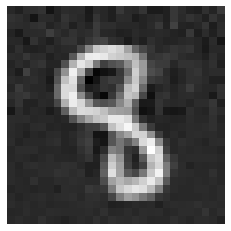

progress in % 6.666666666666667
reconstruction run 2 (loss 304.2)


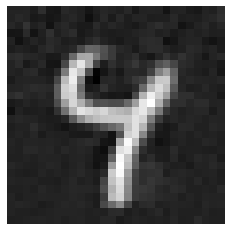

progress in % 13.333333333333334
reconstruction run 3 (loss 339.7)


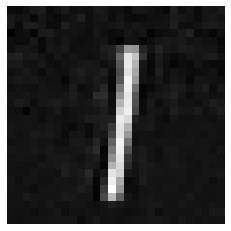

progress in % 20.0
reconstruction run 4 (loss 311.9)


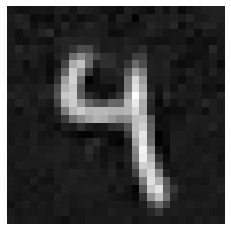

progress in % 26.666666666666668
reconstruction run 5 (loss 311.9)


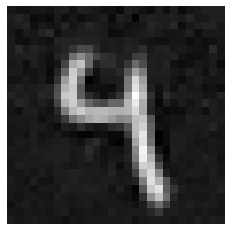

progress in % 33.33333333333333
reconstruction run 6 (loss 304.3)


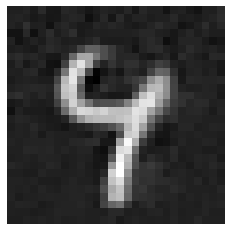

progress in % 40.0
reconstruction run 7 (loss 339.7)


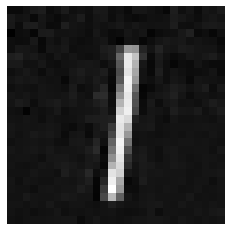

progress in % 46.666666666666664
reconstruction run 8 (loss 304.2)


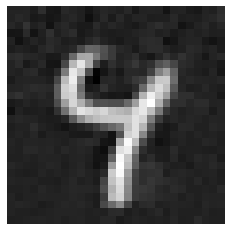

progress in % 53.333333333333336
reconstruction run 9 (loss 304.4)


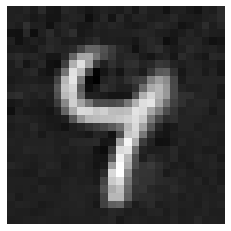

progress in % 60.0
reconstruction run 10 (loss 339.7)


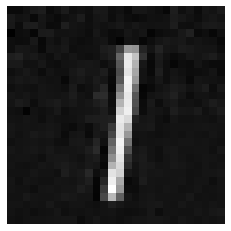

progress in % 66.66666666666666
reconstruction run 11 (loss 311.9)


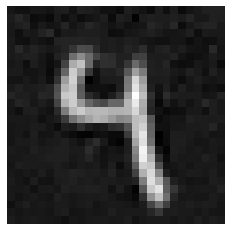

progress in % 73.33333333333333
reconstruction run 12 (loss 304.2)


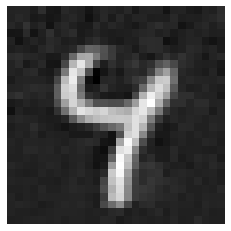

progress in % 80.0
reconstruction run 13 (loss 311.4)


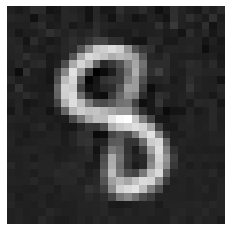

progress in % 86.66666666666667
reconstruction run 14 (loss 311.3)


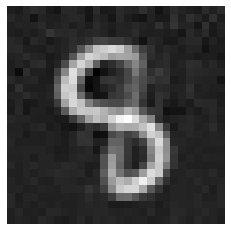

progress in % 93.33333333333333
reconstruction run 15 (loss 311.5)


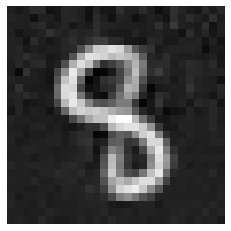

In [17]:
minima  =[]
min_loss=[]
min_var =[]
recons  =[]
for jj,init in enumerate(inits):
    print('progress in %', jj/len(inits)*100)
    min_z, min_l, pos_def    = minimize_posterior(init, data,custom_mask,noise,sess)
    rec                      = sess.run(recon_MAP, feed_dict={sigma_corr:noise})
    var                      = sess.run(variance, feed_dict={input_data: data,mask:custom_mask,sigma_corr:noise})
    print('reconstruction run %d (loss %.1f)'%(jj+1, min_l))
    plot_image(rec, directory=plot_path, filename='recon_%s_minimum%d'%(label,jj), title='reconstruction with loss %.1f'%min_l)
    #If Hessian if positive definite
    if pos_def:
        minima.append(min_z)
        min_loss.append(min_l)
        min_var.append(var)
        recons.append(rec)

Below we order the minimization results in the ascending order so that `minima[0]` corresponds to the latent variable values at the deepest minimum of the negative log posterior, which is the MAP solution.

In [18]:
order    = np.argsort(min_loss)
min_loss = np.asarray(min_loss)[order]
minima   = np.asarray(minima)[order]
min_var  = np.asarray(min_var)[order]

Save your minimization results.

In [19]:
pickle.dump([minima, min_loss, min_var,recons],open(minima_path+'minima_%s.pkl'%label,'wb'))

So even if your kernel died due to the memory overflow, you can retrieve your results by running the below cell. (Uncomment the below cell and run)

In [32]:
minima, min_loss, min_var, recons = pickle.load(open(minima_path+'minima_%s.pkl'%label,'rb'))


FileNotFoundError: ignored

Plot the minimization results.

In [34]:
def plot_minima(minima, losses, var):
    """
    plot the minima for comparison with their width estimated from the variance at these points -> helps decide whether minima are separate
    """
    plt.figure()
    plt.title('Minimization result')
    plt.plot(np.arange(len(losses)),losses,ls='',marker='o')
    plt.xlabel('# iteration')
    plt.ylabel('loss')
    plt.savefig(plot_path+'minimzation_results_%s.png'%(label),bbox_inches='tight')
    plt.show()

    colors = matplotlib.colors.Normalize(vmin=min(losses), vmax=max(losses))
    cmap   = matplotlib.cm.get_cmap('Spectral')

    var = np.squeeze(var)
    plt.figure()
    plt.title('value of hidden variables at minima')
    for ii in range(len(minima)):

        yerr_= np.sqrt(var[ii])

        plt.errorbar(np.arange(hidden_size),np.squeeze(minima)[ii], marker='o',ls='', c=cmap(colors(losses[ii])), mew=0, yerr=yerr_, label ='%d'%losses[ii])
    plt.legend(ncol=4, loc=(1.01,0))
    plt.xlabel('# hidden variable')
    plt.ylabel('value')
    plt.savefig(plot_path+'hidden_values_at_minima_%s.png'%(label),bbox_inches='tight')
    plt.show()

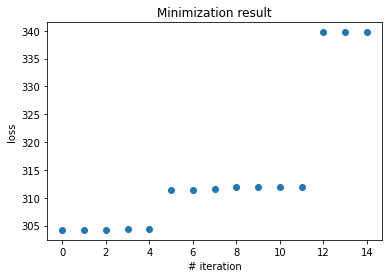

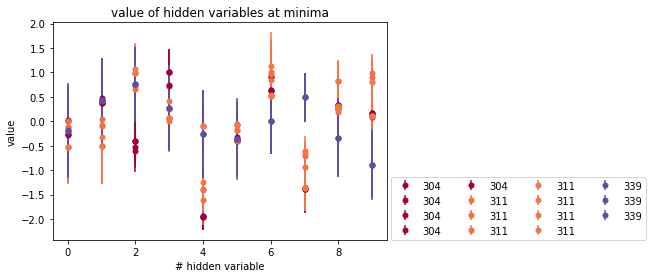

In [22]:
plot_minima(minima, min_loss, min_var)

Finally, set MAP value to the lowest minimum (minima[0])

In [23]:
lowest_minimum = sess.run(MAP_reset, feed_dict={MAP_ini:minima[0]})

Plot the reconstruction results. 

reconstruction from lowest minimum (MAP solution)


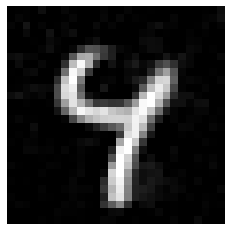

True

In [24]:
print('reconstruction from lowest minimum (MAP solution)')
rec     = sess.run(recon_MAP, feed_dict={sigma_corr:noise})
plot_image(rec, directory=plot_path, filename='lowest_minimum_%s'%(label), title='reconstruction', vmin=0, vmax=1)

Next, let us try stochastic VI (SVI) as a posterior fitting procedure. We use a pre-defined function (see above) 'minimize_neg_elbo' to stochastically minimize the evidence lower bound (ELBO) usig ADAM with decreasing learning rate (the default setting is running with the following learning rate values: 1e-3 with 2000 iterations, 1e-4 with 500 iterations, 1e-5 with 300 iterations - if you have enough memory, you can try more iterations). Here we try both mean field SVI (fitting Gaussians with diagonal) and full rank SVI (full rank covariance).

<span style="color:red"> <i> NOTE: If the kernel dies, you can simply re-load optimization results you saved and start from there.  </i></span> <br>

starting mean field stochastic VI on the posterior
lrate 0.001
iter 0 loss [363.10922]
iter 1000 loss [315.23685]
lrate 0.0001
iter 0 loss [314.56555]
lrate 1e-05
iter 0 loss [315.25836]
time taken 51.321523904800415


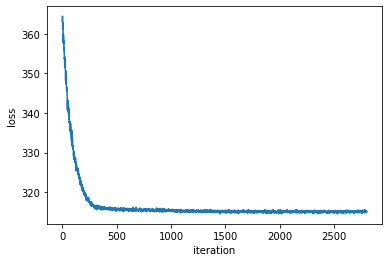

starting full rank stochastic VI on the posterior
lrate 0.001
iter 0 loss [393.55612]
iter 1000 loss [319.87897]
lrate 0.0001
iter 0 loss [315.83987]
lrate 1e-06
iter 0 loss [316.15836]
time taken 52.056904554367065


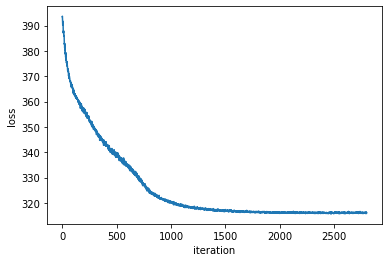

True

In [25]:
sess.run(update_mu_elbo, feed_dict={input_data: data,mask:custom_mask,sigma_corr:noise})
print('starting mean field stochastic VI on the posterior')
minimize_neg_elbo(data,custom_mask,noise,sess)
print('starting full rank stochastic VI on the posterior')
minimize_neg_elbo(data,custom_mask,noise,sess, full_rank=True)

Plot the reconstructed images below:

full rank SVI reconstruction


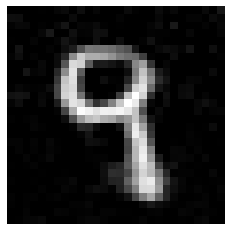

mean field SVI reconstruction


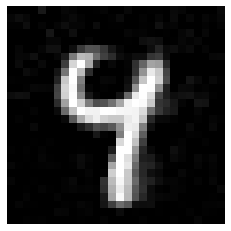

True

In [26]:
print('full rank SVI reconstruction')
rec     = sess.run(recon_fr, feed_dict={sigma_corr:noise})
plot_image(rec, directory=plot_path, filename='full_rank_VI_%s'%(label), title='reconstruction', vmin=0, vmax=1)
print('mean field SVI reconstruction')
rec     = sess.run(recon_elbo, feed_dict={sigma_corr:noise})
plot_image(rec, directory=plot_path, filename='mean_field_VI_%s'%(label), title='reconstruction', vmin=0, vmax=1)


You can observe that full rank SVI results do not look good. That is because we only used a small number of iterations due to the memory limit, suggesting that full rank VI converges to the solution slowly.

Now, we can try the EL$_2$O procedure (See slide 33, Lecture 9) - we find the minimum and fit a full rank Gaussian with the Laplace approximation.

In [16]:
def get_laplace_sample(num,map_value,x,mymask,noise,my_sess):
    """
    samples from the Laplace approximation around the deepest minimum
    """

    my_sess.run(MAP_reset,feed_dict={MAP_ini:map_value})
    my_sess.run(update_mu)
    my_sess.run(update_TriL,feed_dict={input_data: x, mask: mymask, sigma_corr:noise})

    samples=[]
    for ii in range(num):
        my_sess.run(posterior_sample,feed_dict={input_data: x, sigma_corr:noise})
        samples.append(my_sess.run(recon,feed_dict={input_data: x, sigma_corr:noise}))

    samples=np.asarray(samples)
    return samples

def get_gmm_sample(num,x,mymask,noise,my_sess):
    """
    samples from the Gaussian mixture posterior fit
    """

    samples=[]
    for ii in range(num):
        samples.append(my_sess.run(gmm_recon,feed_dict={input_data: x, sigma_corr:noise}))

    samples=np.asarray(samples)
    return samples

def plot_samples(samples, mask, title='samples', filename='samples'):
    """
    plots a compilation of samples
    """
    plt.figure()
    plt.title(title)
    for i in range(min(len(samples),16)):
        subplot(4,4,i+1)
        imshow(np.reshape(samples[i,:],(28,28)),vmin=-0.2,vmax=1.2, cmap='gray')
        axis('off')
    plt.savefig(plot_path+filename+'.png',bbox_inches='tight')
    plt.show()

    if corr_type in ['mask', 'sparse mask', 'noise+mask']:
        plt.figure()
        plt.title('masked'+title)
        for i in range(min(len(samples),16)):
            subplot(4,4,i+1)
            imshow(np.reshape(samples[i,0,:,0]*mask,(28,28)),vmin=-0.2,vmax=1.2, cmap='gray')
            axis('off')     
        plt.savefig(plot_path+filename+'masked.png',bbox_inches='tight')
        plt.show()
        
def get_chi2(sigma,data,mean,masking=True, mask=None,threshold=0.02):
    """
    computes chi2 between data and mean
    """

    if masking:
        mask = np.reshape(mask,data.shape)
        data = data[np.where(mask==1)]
        mean = mean[np.where(mask==1)]
        sigma= sigma[np.where(mask==1)]


    low = min(sigma.flatten())
    high= max(sigma.flatten())

    chi2_tot = np.sum((data-mean)**2/sigma**2)
    dof_tot  = len(np.squeeze(data))

    if corr_type not in ['noise','noise+mask']:
        chi2_low = np.sum((data[np.where(data<=threshold)]-mean[np.where(data<=threshold)])**2/sigma[np.where(data<=threshold)]**2)
        dof_low  = len(np.squeeze(data[np.where(data<=threshold)]))
        chi2_high= np.sum((data[np.where(data>threshold)]-mean[np.where(data>threshold)])**2/sigma[np.where(data>threshold)]**2)
        dof_high = len(np.squeeze(data[np.where(data>threshold)]))
    else:
        chi2_low = None
        dof_low  = None
        chi2_high= None
        dof_high = None

    return chi2_tot, dof_tot, chi2_low, dof_low, chi2_high, dof_high, masking

def probe_posterior(minimum, x, noise, mymask, my_sess, filename=label):
    """
    probes the real posterior along each latent space direction around the minimum and compares to posterior fits
    """

    _ = my_sess.run(MAP_reset,feed_dict={input_data: x, MAP_ini:minimum, sigma_corr:noise})
    _ = my_sess.run(update_mu,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
    _ = my_sess.run(update_TriL,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})

    exact_hessian = sess.run(hessian,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
    approx_hessian= sess.run(GN_hessian,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
    ll0 = sess.run(loss_MAP,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})

    mean_vi, sig_vi, ll0_vi = sess.run([mu_elbo,sigma_elbo, nlPost_elbo],feed_dict={input_data: x, mask:mymask, sigma_corr:noise})


    mean_fr, h_fr, ll0_fr   = sess.run([mu_vi,hess_fr, nlPost_vi],feed_dict={input_data: x, mask:mymask, sigma_corr:noise})


    print(mean_vi)
    print(minimum)

    print(ll0,ll0_vi,ll0_fr)

    plt.figure(figsize=(4*3,3))


    jj =0
    for nn in [5,6,7]:#np.arange(hidden_size):
        H    = exact_hessian[0,nn,nn]
        Hfr  = h_fr[0,nn,nn]
        H_vi = 1./sig_vi[0,nn]**2

        losses=[]

        print(H_vi,H)

        subplot(1,3,jj+1)

        title('latent space direction %d'%nn)

        Delta   = 0.5
        steps   = 2000
        steps_fine = 10000
        delta_z = np.zeros((steps,hidden_size))

        delta_z[:,nn] = (np.arange(steps)-steps//2)*Delta/steps
        new_ini       = delta_z+minimum
        new_ini_vi    = delta_z+mean_vi
        new_ini_fr    = delta_z+mean_fr

        full_span     = np.ones((steps_fine,hidden_size))*minimum
        full_span_min = min(min(new_ini_vi[:,nn]),min(new_ini[:,nn]),min(new_ini_fr[:,nn]))
        full_span_max = max(max(new_ini_vi[:,nn]),max(new_ini[:,nn]),max(new_ini_fr[:,nn]))
        full_span_    = np.linspace(full_span_min,full_span_max,steps_fine)
        full_span[:,nn]= full_span_

        for ii in range(steps_fine):
            _ = sess.run(MAP_reset,feed_dict={input_data: x, mask:mymask, MAP_ini:np.expand_dims(full_span[ii],axis=0), sigma_corr:noise})
            ll = sess.run(loss_MAP,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
            losses.append(ll)


        plt.plot(full_span[:,nn],losses,label='probed posterior', color='crimson',lw=2)
        plt.plot(new_ini[:,nn],ll0+H*delta_z[:,nn]**2,label='EL2O estimate (full rank)',lw=2)
        plt.plot(new_ini_vi[:,nn],ll0_vi+H_vi*delta_z[:,nn]**2,label='mean field SVI estimate',lw=2)
        plt.plot(new_ini_fr[:,nn],ll0_fr+Hfr*delta_z[:,nn]**2,label='full rank SVI estimate',lw=2)

        plt.xlabel('z',fontsize=16)
        plt.ylim(min(min(losses),ll0_fr),max(max(losses),ll0_fr+0.5))
        if jj==0:
            plt.ylabel('negative log posterior',fontsize=14)
            plt.legend(loc='upper right',fontsize=12,framealpha=0.9)
        jj+=1
    plt.tight_layout()




    plt.savefig(plot_path+'probing_posterior_%s.pdf'%(filename),bbox_inches='tight')
    plt.show()

    

def get_gmm_parameters(minima, x, noise, mymask, offset):
    """
    Gaussian mixture model (could be coded more elegantly with softmax function)
    """

    mu   =[]
    w    =[]
    sigma=[]
    for ii in range(num_comp):

        # do Laplace approximation around this minimum
        mu+=[minima[ii]]
        sess.run(MAP_reset,feed_dict={MAP_ini:minima[ii]})
        sigma+=[sess.run(update_TriL,feed_dict={input_data: x, sigma_corr:noise, mask: mymask})]

        # correct weighting of different minima according to El20 procedure, with samples at the maxima and well seperated maxima
        logdet  = sess.run(tf.linalg.logdet(approx_posterior_laplace.covariance()),feed_dict={input_data: x, sigma_corr:noise, mask: mymask})
        logprob = sess.run(nlPost_MAP,feed_dict={input_data: x, sigma_corr:noise, mask: mymask})
        w+=[np.exp(0.5*logdet+logprob+offset)]

    print('weights of Gaussian mixtures:', w/np.sum(w))
    mu     = np.reshape(np.asarray(mu),[1,num_comp,hidden_size])
    sigma  = np.reshape(np.asarray(sigma),[1,num_comp,hidden_size,hidden_size])
    w      = np.squeeze(np.asarray(w))

    return mu, sigma, w

def plot_prob_2D_GMM(samples, indices):
    '''
    makes corner plots of the posterior samples
    '''

    samples = samples[:,0,:]

    samples = np.hstack((np.expand_dims(samples[:,indices[0]],-1),np.expand_dims(samples[:,indices[1]],-1)))

    figure=corner.corner(samples)
    axes = np.array(figure.axes).reshape((2, 2))

    axes[1,0].set_xlabel('latent space variable %d'%indices[0])
    axes[1,0].set_ylabel('latent space variable %d'%indices[1])
    plt.savefig(plot_path+'posterior_contour_GMM_%s_latent_space_dir_%d_%d.png'%(label,indices[0],indices[1]),bbox_inches='tight')
    plt.show()
    
  

We draw 10 samples from the deepest minimum using the Laplace approximation.

In [28]:
samples = get_laplace_sample(10,minima[0],data,custom_mask,noise,sess)

Plot the samples (with and without mask) using a pre-defined function 'plot_samples'

samples from Laplace approximation around deepest minimum (EL2O)


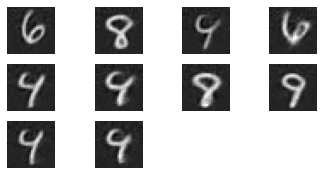

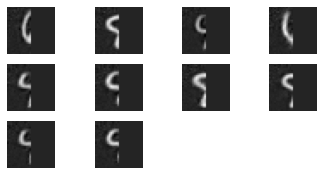

In [29]:
print('samples from Laplace approximation around deepest minimum (EL2O)')
plot_samples(samples, custom_mask, title='Samples from Laplace approximation', filename='samples_laplace_deepest_minimum_%s'%label)  

Or we can use a mixture of multivariate Gaussians (GMM) as posterior approximation. Under the assumption of well separated mixture components, the EL$_2$O procedure for a GMM involves the following 3 steps: 1) finding all relevant minima in the posterior by optimization, 2) fitting Gaussians around these minima by using the Laplace approximation, 3) improving the probability distribution beyond the Gaussian approximation, if needed, 4) finding the relative weights of these mixture components. See the above pre-defined functions for referenes.

Remember that you had 15 different minimization results. How many minima points did it have? 
![alt text](https://drive.google.com/uc?id=16o9XR23RpRXQm-QwExHOwzG18H8B8kXx)
In the above plot, you can clearly see three separate minima: iteration 0-1, 2-7, 8-9. Then, you can choose three different minima: minima[0], minima[2], minima[8]. Now, with such minima identified, we fit Gaussians around them and determine their relative weights. Number of Gaussian components we are going to use is determined by `num_comp` variable you set earlier.

In [30]:
minima[0]

array([[-0.27146694,  0.36991692, -0.41030383,  1.0177977 , -1.9596066 ,
        -0.4002436 ,  0.61851865, -1.380274  ,  0.33689618,  0.17736487]],
      dtype=float32)

In [31]:
# here, the separate minima have to be set by hand. Take a look at your optimization results and choose three 
#different minima.
# Suppose you wish to choose the following three different minima: minima[0],minima[4],minima[14]
# Then, you can do: mu_, sigma_, w_ = get_gmm_parameters([minima[0],minima[4],minima[14]], data, noise, custom_mask, min_loss[0])

mu_, sigma_, w_ = get_gmm_parameters([minima[0],minima[4],minima[14]], data, noise, custom_mask, min_loss[0])
_ = sess.run([update_w, update_mugmm,update_TriLgmm], feed_dict={mu_ini:mu_, w_ini:w_, sigma_ini:sigma_ })

weights of Gaussian mixtures: [[7.3162216e-01]
 [2.6837778e-01]
 [9.8523566e-13]]


This is a simple unimodal posterior example, so you should find that the first minima dominates, and the other two are negligible.

Finally, take 10 samples from GMM and plot them.

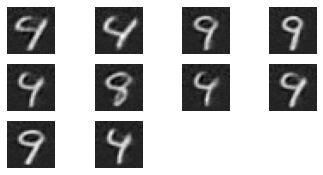

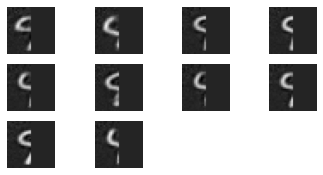

In [32]:
samples = get_gmm_sample(10,data,custom_mask,noise,sess)
plot_samples(samples, custom_mask, title='GMM samples', filename='gmm_samples_%s'%label)  

Now, take 10000 from GMM and plot the posterior in the latent variable space using the corner package. Plot the posterior between latent variable 0 and 1, 1 and 2, and 3 and 8.

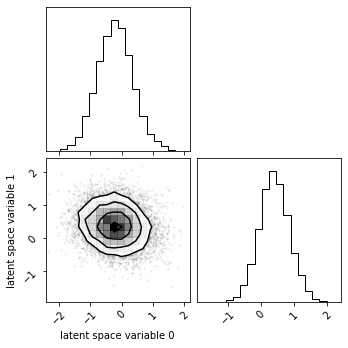

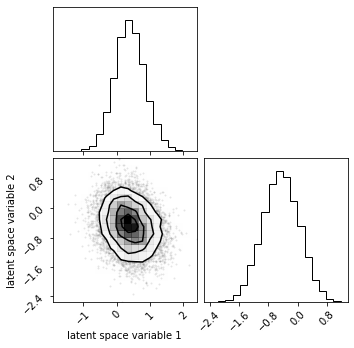

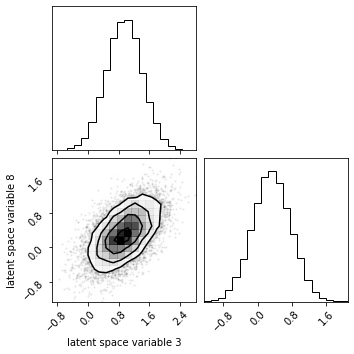

In [33]:
more_samples = []
for ii in range(10000):
    more_samples+=[sess.run(gmm_sample,feed_dict={input_data: data, sigma_corr:noise})]
more_samples=np.asarray(more_samples)

for indices in [[0,1],[1,2],[3,8]]:
    plot_prob_2D_GMM(more_samples, indices)

Finally, using a pre-defined function 'probe_posterior', we make a comparison of posterior fits obtained with different fitting procedures to the probed true posterior. We show 3 randomly chosen latent space directions of the 10 dimensional latent space.

[[ 0.3193234   0.47465867  0.1914752   1.3270686  -1.604804   -0.884165
   1.753448   -1.3482476   0.3678901   0.4887203 ]]
[[-0.27146694  0.36991692 -0.41030383  1.0177977  -1.9596066  -0.4002436
   0.61851865 -1.380274    0.33689618  0.17736487]]
304.23007 305.89307 314.68134
58.607002489603026 355.15775
9.583588598317565 28.181292
120.39069964362243 93.24565


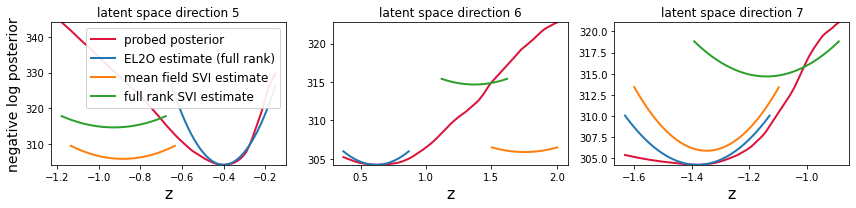

In [34]:
probe_posterior(minima[0], data, noise, custom_mask, sess)

You should be able to observe that EL$_2$O gives high quality posteriors in latent space and in data space!

# PROBLEM STARTS HERE

<span style="color:blue"> <i> 1. Using the corrupted data shown below (a broad mask is applied such thata different digits like 4s and 9s are compatible with the data - so you will be able to see a multimodal posterior!), perform the posterior analysis. </i></span> <br>
    
<span style="color:blue"> <i>(1) When you run optimization to find all local minima of the log posterior, use the following learning rate/number of iteration: 1e-1 with 10000 iterations, 1e-2 with 5000 iterations, 1e-3 with 3000 iterations. (it will take quite a bit of time to run this!) Do 10 runs. Make sure to save your results so that you don't need to run this again.</i></span> <br>

<span style="color:blue"> <i>(2) Run the full rank SVI with learning rate of 1e-3 with 3500 iterations, 1e-4 with 500 iterations, and 1e-5 with 500 iterations. Skip the mean field SVI. Make a comparison of the negative log posterior at the first two minimum with EL$_2$O vs. full rank SVI. </i></span> <br>

<span style="color:blue"> <i>(3) Fit for 5 different GMM components (corresponding to 5 different minima). Show that the first two dominates and the other three have only negligible contribution.</i></span> <br>
    

<span style="color:red"> <i> NOTE: If the kernel dies when running SVI, you can simply re-load optimization results you saved and start from there.  </i></span> <br>

In [17]:
data_dim    = 28*28
data_size   = 1
sigma_n     = 0.1
hidden_size = 10
n_channels  = 1
seed        = 777
sample_size = 512

# settings for reconstrcution with rectangular mask
corr_type   = 'mask'
num_mnist   = 6
label       = 'solidmask'
noise_level = 0.0

In [18]:
num_comp = 5

Truth:


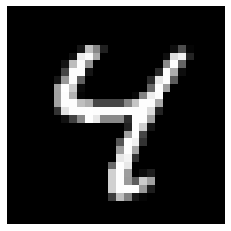

Data:


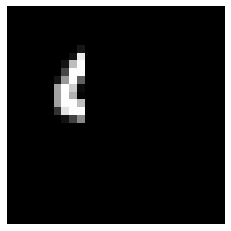

True

In [19]:
# create underlying truth
truth = x_test[num_mnist:num_mnist+data_size]
# create corrupted data
data, custom_mask = make_corrupted_data(truth, corr_type=corr_type)
# noise
noise = get_custom_noise(data.shape, signal_dependent=False, signal=truth)

# Make plot
print('Truth:')
plot_image(truth, directory=plot_path, filename='truth_%s'%label, title='truth')
print('Data:')
plot_image(data, directory=plot_path, filename='input_data_%s'%label, title='data')

In [20]:
def probe_posterior(minimum, x, noise, mymask, my_sess, filename=label):
    """
    make comparison: EL2O vs. full rank VI
    probes the real posterior along each latent space direction around the minimum and compares to posterior fits
    """

    _ = my_sess.run(MAP_reset,feed_dict={input_data: x, MAP_ini:minimum, sigma_corr:noise})
    _ = my_sess.run(update_mu,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
    _ = my_sess.run(update_TriL,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})

    exact_hessian = sess.run(hessian,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
    approx_hessian= sess.run(GN_hessian,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
    ll0 = sess.run(loss_MAP,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})


    mean_fr, h_fr, ll0_fr   = sess.run([mu_vi,hess_fr, nlPost_vi],feed_dict={input_data: x, mask:mymask, sigma_corr:noise})

    plt.figure(figsize=(4*3,3))


    jj =0
    for nn in [5,6,7]:#np.arange(hidden_size):
        H    = exact_hessian[0,nn,nn]
        Hfr  = h_fr[0,nn,nn]

        losses=[]

        subplot(1,3,jj+1)

        title('latent space direction %d'%nn)

        Delta   = 0.5
        steps   = 2000
        steps_fine = 10000
        delta_z = np.zeros((steps,hidden_size))

        delta_z[:,nn] = (np.arange(steps)-steps//2)*Delta/steps
        new_ini       = delta_z+minimum
        new_ini_fr    = delta_z+mean_fr

        full_span     = np.ones((steps_fine,hidden_size))*minimum
        full_span_min = min(min(new_ini_fr[:,nn]),min(new_ini[:,nn]),min(new_ini_fr[:,nn]))
        full_span_max = max(max(new_ini_fr[:,nn]),max(new_ini[:,nn]),max(new_ini_fr[:,nn]))
        full_span_    = np.linspace(full_span_min,full_span_max,steps_fine)
        full_span[:,nn]= full_span_

        for ii in range(steps_fine):
            _ = sess.run(MAP_reset,feed_dict={input_data: x, mask:mymask, MAP_ini:np.expand_dims(full_span[ii],axis=0), sigma_corr:noise})
            ll = sess.run(loss_MAP,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
            losses.append(ll)


        plt.plot(full_span[:,nn],losses,label='probed posterior', color='crimson',lw=2)
        plt.plot(new_ini[:,nn],ll0+H*delta_z[:,nn]**2,label='EL2O estimate (full rank)',lw=2)
        plt.plot(new_ini_fr[:,nn],ll0_fr+Hfr*delta_z[:,nn]**2,label='full rank SVI estimate',lw=2)

        plt.xlabel('z',fontsize=16)
        plt.ylim(min(min(losses),ll0_fr),max(max(losses),ll0_fr+0.5))
        if jj==0:
            plt.ylabel('negative log posterior',fontsize=14)
            plt.legend(loc='upper right',fontsize=12,framealpha=0.9)
        jj+=1
    plt.tight_layout()




    plt.savefig(plot_path+'probing_posterior_%s.pdf'%(filename),bbox_inches='tight')
    plt.show()

    

# Problem 1.1 

In [21]:
lrate_run1 = np.array([1e-1, 1e-2, 1e-3])
numiter_run1 = np.array([10000,5000,3000])

progress in % 0.0
reconstruction run 1 (loss -485.2)


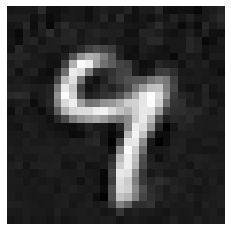

progress in % 6.666666666666667
reconstruction run 2 (loss -483.9)


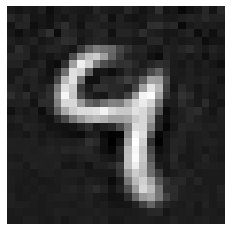

progress in % 13.333333333333334
reconstruction run 3 (loss 200.1)


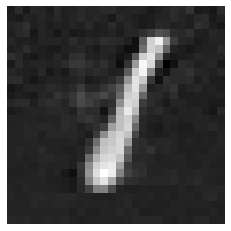

progress in % 20.0
reconstruction run 4 (loss -485.2)


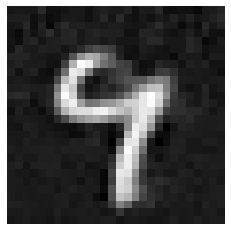

progress in % 26.666666666666668
reconstruction run 5 (loss -485.2)


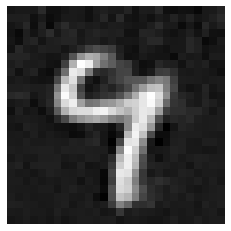

progress in % 33.33333333333333
reconstruction run 6 (loss -483.9)


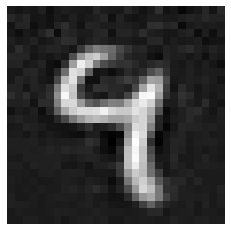

progress in % 40.0
reconstruction run 7 (loss 200.1)


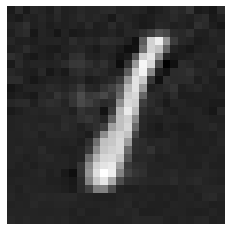

progress in % 46.666666666666664
reconstruction run 8 (loss -479.7)


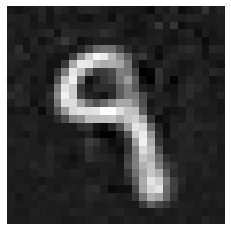

progress in % 53.333333333333336
reconstruction run 9 (loss -483.9)


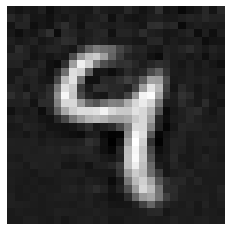

progress in % 60.0
reconstruction run 10 (loss -483.9)


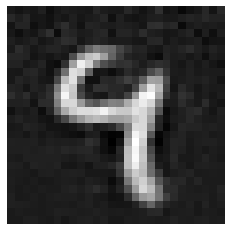

progress in % 66.66666666666666
reconstruction run 11 (loss -483.9)


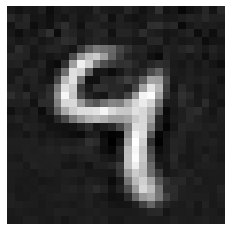

progress in % 73.33333333333333
reconstruction run 12 (loss -484.3)


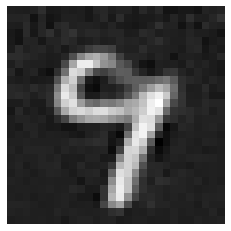

progress in % 80.0
reconstruction run 13 (loss -483.9)


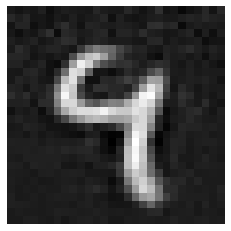

progress in % 86.66666666666667
reconstruction run 14 (loss -473.8)


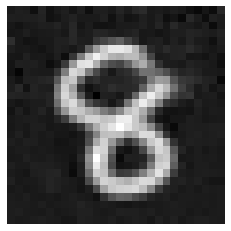

progress in % 93.33333333333333
reconstruction run 15 (loss -485.2)


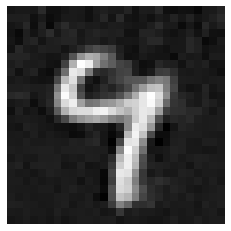

In [40]:
# probe_posterior(minima[0], data, noise, custom_mask, sess, filename=label)
minima  =[]
min_loss=[]
min_var =[]
recons  =[]
for jj,init in enumerate(inits):
    print('progress in %', jj/len(inits)*100)
    min_z, min_l, pos_def    = minimize_posterior(init, data,custom_mask,noise,sess)
    rec                      = sess.run(recon_MAP, feed_dict={sigma_corr:noise})
    var                      = sess.run(variance, feed_dict={input_data: data,mask:custom_mask,sigma_corr:noise})
    print('reconstruction run %d (loss %.1f)'%(jj+1, min_l))
    plot_image(rec, directory=plot_path, filename='recon_%s_minimum%d'%(label,jj), title='reconstruction with loss %.1f'%min_l)
    #If Hessian if positive definite
    if pos_def:
        minima.append(min_z)
        min_loss.append(min_l)
        min_var.append(var)
        recons.append(rec)

In [41]:
order    = np.argsort(min_loss)
min_loss = np.asarray(min_loss)[order]
minima   = np.asarray(minima)[order]
min_var  = np.asarray(min_var)[order]

In [42]:
pickle.dump([minima, min_loss, min_var,recons],open(minima_path+'minima_1p2_%s.pkl'%label,'wb'))

In [22]:
minima, min_loss, min_var, recons = pickle.load(open(minima_path+'minima_1p2_%s.pkl'%label,'rb'))

# Problem 1.2

In [23]:
lrate_run1 = np.array([1e-3, 1e-4, 1e-5])
numiter_run1 = np.array([3500,500,500])

starting full rank stochastic VI on the posterior
lrate 0.001
iter 0 loss [895.89734]
iter 1000 loss [74.31398]
lrate 0.0001
iter 0 loss [-398.5365]
lrate 1e-06
iter 0 loss [-400.61456]
time taken 52.93361186981201


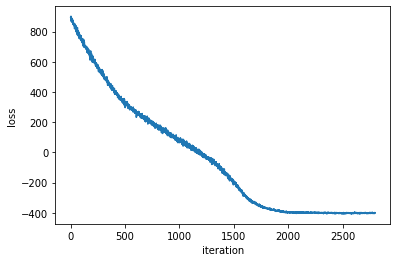

True

In [24]:
sess.run(update_mu_elbo, feed_dict={input_data: data,mask:custom_mask,sigma_corr:noise})

print('starting full rank stochastic VI on the posterior')
minimize_neg_elbo(data,custom_mask,noise,sess, full_rank=True)

full rank SVI reconstruction


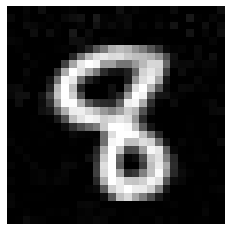

True

In [25]:
print('full rank SVI reconstruction')
rec     = sess.run(recon_fr, feed_dict={sigma_corr:noise})
plot_image(rec, directory=plot_path, filename='full_rank_VI_%s'%(label), title='reconstruction', vmin=0, vmax=1)

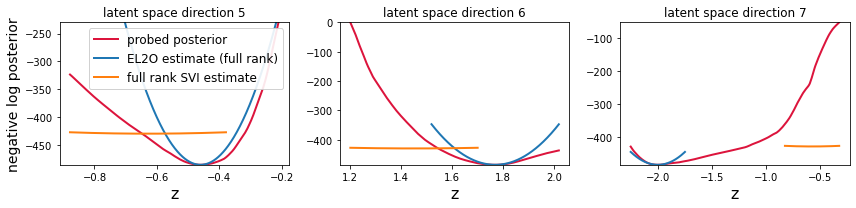

In [26]:
probe_posterior(minima[0], data, noise, custom_mask, sess)

#Problem 1.3

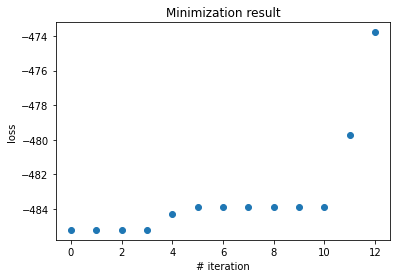

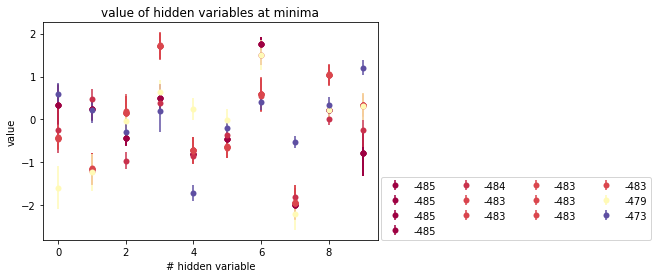

In [35]:
plot_minima(minima, min_loss, min_var)

it is clear above that the first two images resemble the 4 the strongest by eye, and the following 3 look more like the 9. The truth is the 4 but we see the similar peak in the posterior that looks like the 9. 

In [43]:
num_comp = 5
##### for Gaussian mixture model fit around minima #####
ini_val2    = np.ones((data_size,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
    mu_gmm      = tf.Variable(np.ones((data_size,num_comp,hidden_size)), dtype=np.float32)
    sigma_gmm   = tf.Variable(tfd.fill_triangular(ini_val2))
    w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)

sigma_gmmt    = tfd.matrix_diag_transform(sigma_gmm, transform=tf.nn.softplus)
w_positive    = tf.math.softplus(w_gmm)
w_rescaled    = tf.squeeze(w_positive/tf.reduce_sum(w_positive))

gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_rescaled),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

mu_ini        = tf.placeholder_with_default(tf.zeros([data_size,num_comp,hidden_size]),shape=[data_size,num_comp,hidden_size])
sigma_ini     = tf.placeholder_with_default(tf.ones([data_size,num_comp,hidden_size, hidden_size]),shape=[data_size,num_comp,hidden_size, hidden_size])
w_ini         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

update_w      = tf.stop_gradient(w_gmm.assign(softplus_inverse(w_ini)))
update_mugmm  = tf.stop_gradient(mu_gmm.assign(mu_ini))
update_TriLgmm= tf.stop_gradient(sigma_gmm.assign(tfd.matrix_diag_transform(sigma_ini, transform=softplus_inverse)))

gmm_sample    = gmm.sample()
gmm_recon     = get_recon(generator,nvp_funcs, gmm_sample ,sigma_corr,mask)
####################################################
mu_, sigma_, w_ = get_gmm_parameters([minima[0],minima[4],minima[5], minima[11], minima[12]], data, noise, custom_mask, min_loss[0])
_ = sess.run([update_w, update_mugmm,update_TriLgmm], feed_dict={mu_ini:mu_, w_ini:w_, sigma_ini:sigma_ })

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
weights of Gaussian mixtures: [[2.5224397e-01]
 [7.3827289e-02]
 [6.7150587e-01]
 [2.4180615e-03]
 [4.8280535e-06]]


In [42]:
print(np.shape(sigma_))

(1, 5, 10, 10)


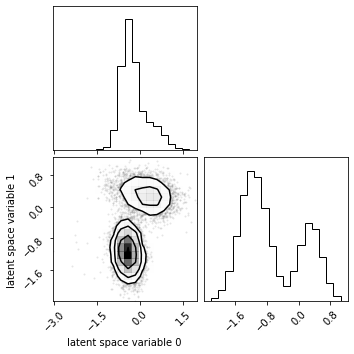

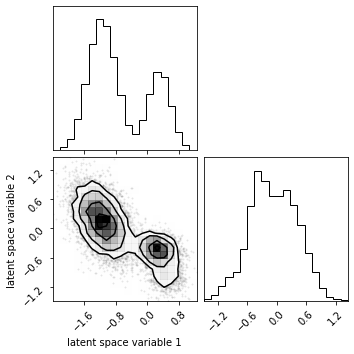

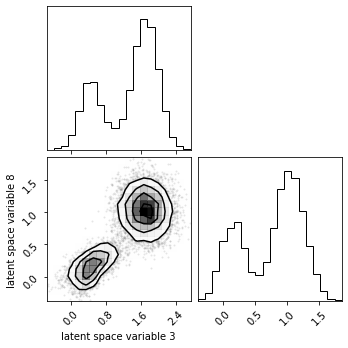

In [44]:
more_samples = []
for ii in range(10000):
    more_samples+=[sess.run(gmm_sample,feed_dict={input_data: data, sigma_corr:noise})]
more_samples=np.asarray(more_samples)

for indices in [[0,1],[1,2],[3,8]]:
    plot_prob_2D_GMM(more_samples, indices)

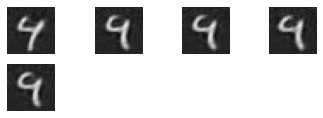

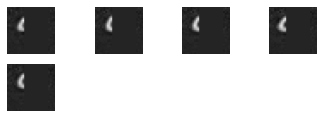

In [46]:
samples = get_gmm_sample(num_comp,data,custom_mask,noise,sess)
plot_samples(samples, custom_mask, title='GMM samples', filename='gmm_samples_%s'%label) 

***

In [48]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rec', 'indices', 'var', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [49]:
# general plot params
params = {
          'axes.labelsize' : 24,
          'xtick.labelsize' : 16,
          'ytick.labelsize' : 16,
          'figure.figsize'  : (14,7),
         }
plt.rcParams.update(params)

#### Problem 2. Bayesian Evidence

The Bayesian evidence for hypothesis $H$, given data $x$ and a model with parameters $z$, is given by

$$p(x| H) = \int dz ~p(x|z,H) p(z|H), $$

where $p(x|z,H)$ is the likelihood and $p(z|H)$ the prior. For a likelihood with a single mode located at $z=\mu$, one can approximate the evidence using the Laplace approximation to give

$$p(x| H) \approx (2 \pi)^{M/2} \sqrt{\det \Sigma} p(x|\mu,H) p(\mu|H) ,$$

where $M$ is the dimensionality of the parameters, and $\Sigma$ is the covariance matrix. If there is no correlation between parameters then the determinant of the covariance matrix is given by the product of the square of the errors of each parameter

$$ \det \Sigma = \prod_{i=1}^M \sigma_i^2 .$$

For simplicity, we assume no correlation in this assignment.

To gain intuition for this equation one can define the prior volume as $V_{\rm prior} = 1/p(\mu|H)$ and the posterior volume as $V_{\rm posterior} = (2 \pi)^{M/2} \sqrt{{\rm det} \Sigma}$. Thus the evidence can be written as 

$$p(x| H) \approx p(x|\mu,H) \frac{V_{\rm posterior}}{V_{\rm prior}} .$$


Hence the Bayesian evidence is approximatey equal to the maximum likelihood multiplied by the posterior-to-prior volume ratio. Becuase the posterior volume is typically narrower than the prior, the evidence will be less than the likelihood. The posteriror-to-prior volume ratio acts as a penalty on the likelihood to account for model complexity. In cases where the prior volume is much larger than the posterior volume, a large penalty will be induced.

For a hypothesis test, Bayes factor is used to compare the Bayesian evidence ratio of two hypotheses. Often one is interested in comparing some hypothesis $H$ to a null hypothesis $H_0$. In such a case Bayes factor is defined as

$$ B \equiv \frac{p(x|H)}{p(x|H_0)} \approx \frac{ p(x|\mu,H)}{p(x|H_0)} \frac{V_{\rm posterior}}{V_{\rm prior}},$$

where in the final step we have applied the Laplace approximation. It can be seen that the Bayes factor is equal to the likelihood ratio multiplied by the posteriror-to-prior volume ratio.

In this excercise we will apply Bayesian evidence in the presence of the look-elsewhere effect, which occurs when the prior volume is much larger than the posterior volume. One of the great powers of the Bayesian approach is that it has a built in correction for the look-elsewhere effect and other forms of model complexity thanks to the posterior-to-prior volume ratio.


#### The look-elsewhere effect

A common problem in statistical analysis is to find evidence for
a physical signal
in a large, continuous parameter space, where the true position of the signal is not known a priori. 
By searching over a wide 
parameter 
space one increases the probability of finding large signals caused by random statistical fluctuations, as opposed to a physical source. This is known as the look-elsewhere effect -- or sometimes the "problem of multiple comparisons" in discrete cases -- 
and must be accounted for when performing a hypothesis test. Ignoring this effect would lead to an overestimation of the statistical significance, sometimes by a considerable amount, and thus incorrectly concluding the detection of a physical signal. 

The look-elsewhere effect is prominent throughout particle physics and cosmology.  One of the most commonly known occurrences is in collider searches for new particles, for example it was a key consideration in the Higgs boson discovery.  In this example, one searches a large range of masses for a resonance, without a priori knowledge of the true mass of the particle.  Similarly, in astrophysical searches for particles one seeks resonances in the energy flux of various astrophysical spectra, where the true energy signature of the particle is unknown.  Examples include:  constraining the dark matter self-annihilation cross-section via gamma ray emission from galaxy clusters, searching for WIMPs via charged cosmic rays, searching for non-baryonic dark matter via X-ray emission from the Milky Way, and explaining the source of high energy astrophysical neutrinos.  In terms of cosmology, the look-elsewhere effect occurs in searches for gravitational wave signals from black hole or neutron star mergers.  Here one searches large time series for a signal, where the time and shape of the event are unknown.  A further cosmological example is searching for signatures of inflation in the primordial power spectrum. The look-elsewhere effect is also prevalent in other areas of physics and beyond, for example:  in astronomy it occurs when detecting exoplanets via stellar photometry, where the period and phase of  the  planets’  transits  are  unknown;  in  biology  it  occurs  when  considering  large  DNA sequences to study genetic association; and in medicine it occurs when testing the effectiveness of drugs in clinical trials.

#### Cosmological Inflation Example

We consider a search to find a signal for non-gaussianities in the primordial power spectrum using Planck data. A specific type of such a model adds the following oscillatory perturbation to the $\Lambda$CDM power spectrum,

$$ P(k) = P_0(k) [1 + A \sin(2 \omega k + \phi)], $$

where $P_0(k)$ is the featureless ($\Lambda$CDM) power spectrum and $A$, $\omega$, and $\phi$ are the amplitude, frequency, and phase of the oscillatory perturbation. Specifically we search for a signal with frequency between 0 and 4,000, and phase between 0 and $2 \pi$. We assume the signal is equally likely to apppear anywhere in paramerter space a priori. In this context the null hpothesis $H_0$ corresponds to $A=0$, i.e. no signal, while the alternative hypothesis $H$ corresponds to $A>0$.

In a full analysis one would fit for all 3 parameters, but, for the sake of simplicity, we will assume that the maximization over amplitude and phase has already been performed. We thus focus on $\omega$, which contributes most to the look-elsewhere effect.

First, load the data and plot the likelihood ratio $L/L_0 \equiv { p(x|z,H)}/{p(x|H_0)} $ as a function of frequency $\omega$. Note the likelihood is already evaluated at the best fit value of $A$ and $\phi$.

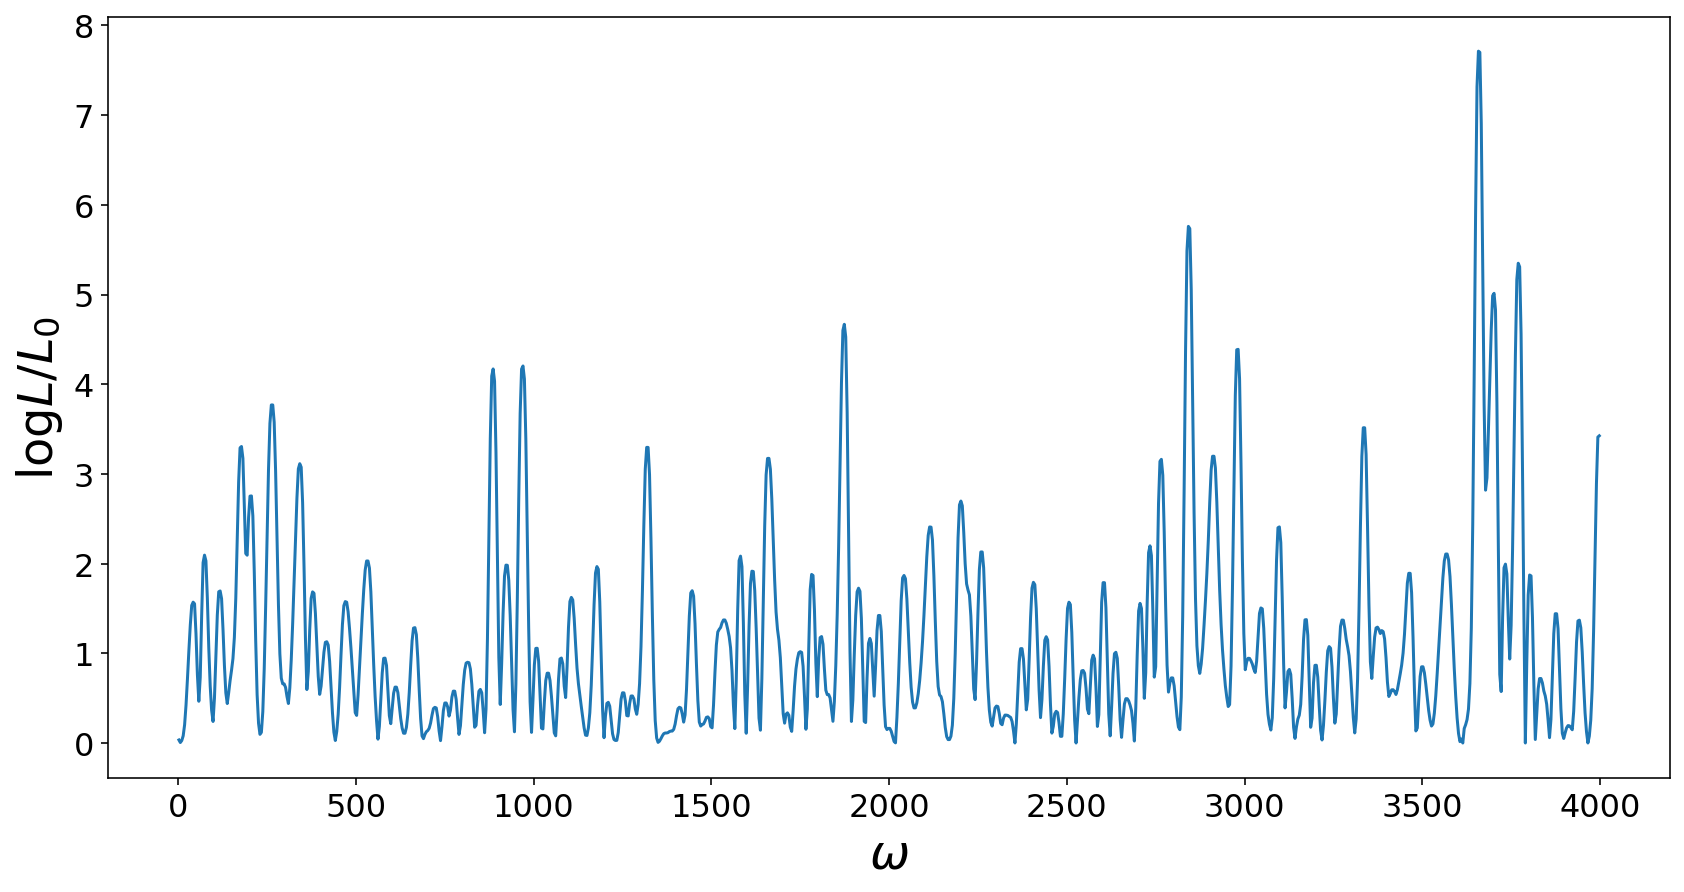

In [50]:
# load the data
data = dict(np.load('/content/drive/My Drive/P188_288/P188_288_HW7/planck13data.npz'))
omega = data['omega']
logL = data['logL']      # logL evaluated at omega
logL0 = data['logL0']

# compute log L/L0
LL = logL - logL0

# plot the data
plt.figure()
plt.plot(omega, LL)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\log L/L_0$')
plt.show()

Because the search for a signal considers any frequency between 0 and 4,000, the prior volume for the frequency is very large. This leads to the likelihood  being multimodal,  with  many (potentially all) of the peaks corresponding to  noise  fluctuations  rather  than a physical  source. This is the look-elsewhere effect: by considering a large prior volume one invites the possibility of finding many large peaks which are just statistical fluctuations.

We see the maximum likelihood occurs at around $\omega=3660$. Naively, one might compute the root chi-squared at this peak to determine the significance. We will start by doing this.

Approximating peaks as gaussians, the chi-squared is equal to $2 \log L /L_0$. The provided likelihood is discretely sampled over $\omega$, so to estimate the height, width, and location of the peak in frequency space a simple approach is to find the datapoint with maximum likelihood and fit a gaussian through it and adjacent data points. (As mentioned earlier, a more careful analysis would directly optimize and compute the covariance matrix of the likelihood in the space of all 3 parameters $A, \omega, {\rm and } \, \phi$.)

<span style="color:blue"> <i> 1. By applying a gaussian fit, or otherwise, find the location of the maximum, i.e. the best fit $\omega$, the value of $\log L/ L_0$ at the maximum, and the error  $\sigma_\omega$. Print their values.</i></span>

<span style="color:blue"><i>  Next, make a plot of the Gaussian fit and the data around the peak.</i></span>

Hint: Fit the gaussian to the likelihood ratio, not the log likelihood ratio. We have done a similar problem in HW1.5

In [51]:
max_L = np.max(LL)
max_index = np.argmax(LL)
max_omega = omega[max_index]

print("Maximum ω is: {0:0.3f} Hz".format(max_omega))
print("Maximum log L/L_0 is: {0:0.3f}".format(max_L))

Maximum ω is: 3658.000 Hz
Maximum log L/L_0 is: 7.713


amp=2439.844+/-46.591
mu=3659.346+/-0.111
sigma= 5.035+/-0.111


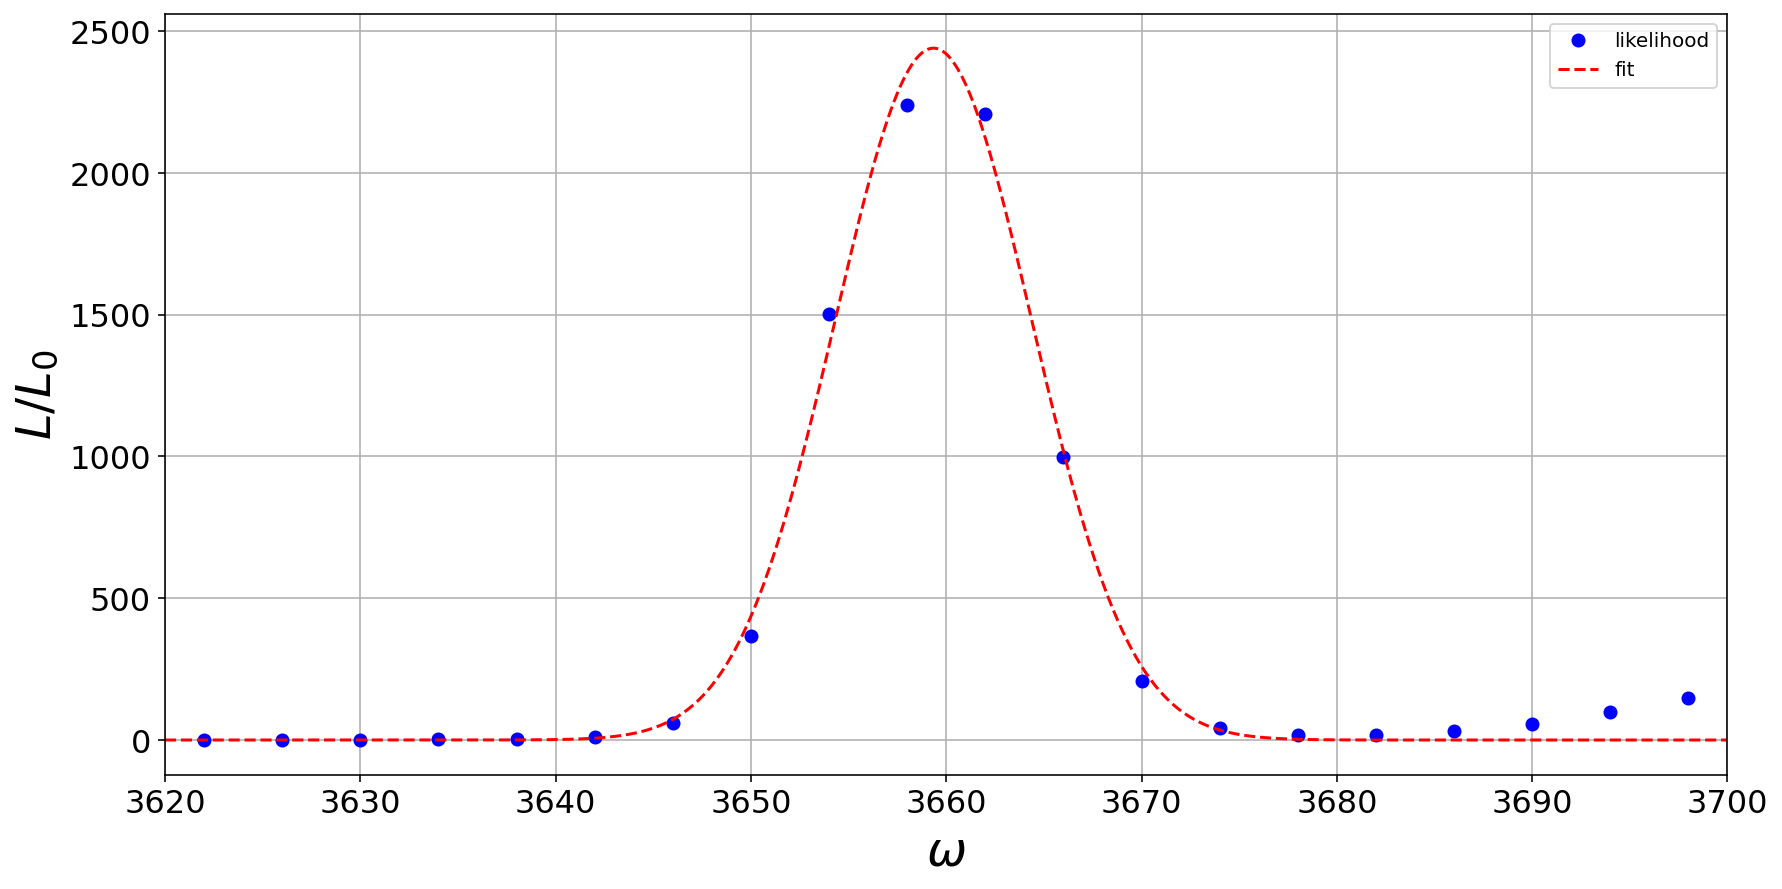

In [52]:
# Estimate the error on L  by fitting to a gaussian at the peak
# Import packages for curve fitting
from scipy.optimize import curve_fit

# Create an array of ω near ω_max
# omega_small = np.linspace(max_omega-5, max_omega+5, 100)
omega_small = omega[max_index - 20: max_index+20]
likelihood_small = np.exp(LL[max_index - 20:max_index + 20])

# Define Gaussian function with arbitrary amplitude (See https://en.wikipedia.org/wiki/Normal_distribution)
def gaussian(x, Amp, mu, sig):
    return Amp * np.exp(-0.5 * ((x-mu)/(sig))**2)

# Fit a Gaussian function to a data
#(https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)
# You can use different packages if you wish. This is only a suggestion.

par0 = np.array([2000, 3650, 1.0]) # initial guess for parameters
par, cov = curve_fit(gaussian, omega_small, likelihood_small, par0) #fitter.curve_fit takes in the model, x,y data, guess, and sigma

a_ = par[0]
ea_ = np.sqrt(cov[0,0])
print('amp={0:6.3f}+/-{1:5.3f}'.format(a_,ea_))
b_ = par[1]
eb_ = np.sqrt(cov[1,1])
print('mu={0:6.3f}+/-{1:5.3f}'.format(b_,eb_))
c_ = par[2]
ec_ = np.sqrt(cov[2,2])
print('sigma={0:6.3f}+/-{1:5.3f}'.format(c_,ec_))

# Plot both data and fit
new_omega = np.linspace(3620, 3700, 1000)
plt.plot(omega_small, likelihood_small, 'bo', label = 'likelihood')
plt.plot(new_omega, gaussian(new_omega, a_, b_, c_) , 'r--', label='fit')
plt.xlim(3620, 3700)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$L/L_0$')
plt.grid()
plt.legend()
plt.show()

<span style="color:blue"> <i> 2. Compute the root chi-squared of the maximum peak, assuming it is a Gaussian. This gives the naive significance of the sigal without considering the look-elsewhere effect. Print its value.
</i></span>

In [53]:
chi_squared = 2*np.log(a_)

print("The root χ^2 value is: {0:0.3f}".format(np.sqrt(chi_squared)))


The root χ^2 value is: 3.950


You should find the root chi-squared, to be around 4. This, naively, means that a detection at the level of 4 sigma has been made. While physicists typically set the level to announce a detection at 5 sigma, 4 sigma is still  quite a significant result and would likely attract some media attention. However, the root chi-squared, and more fundamentally the likelihood ratio, does not take into account the look-elsewhere effect. Because a large prior volume introcudes many spurious peaks due to statistical fluctuations, the significance must be penalized. As discussed above, Bayes factor does this for free. 

<span style="color:blue"> <i> 3. Compute Bayes factor and print its value:
</i></span>    
$$ B \equiv \frac{p(x|H)}{p(x|H_0)} \approx \frac{ p(x|\mu,H)}{p(x|H_0)} \frac{V_{\rm posterior}}{V_{\rm prior}},$$
where the prior volume and the posterior volume are defined as $V_{\rm prior} = 1/p(\mu|H)$ and $V_{\rm posterior} = (2 \pi)^{M/2} \sqrt{{\rm det} \Sigma}$.

Note:
The Bayes factor should technically be computed by adding the contributions of all peaks, as the evidence is an integral over parameter space. However, because the maximum likelihood peak here is much higher than the others, it suffices to only consider the contribution to the Bayes factor from the maximum
mode.

Hint:
Use all 3 likelihood parameters, $A, \omega, \phi$. We provide the errors on $A$ and $\phi$ for the maximum peak, as well as the prior volume on the amplitude in the cell below.

In [54]:
# given amplitude and phase information
sigma_A = 0.03901713
Vprior_A = 0.153240657
sigma_omega = c_
sigma_phi = 0.46561369 

sigma_params = np.array([sigma_A, sigma_omega, sigma_phi])
det_Sigma=1
for i in range(len(sigma_params)):
  det_Sigma *= sigma_params[i]**2

M = len(sigma_params)
Vposterior = (2*np.pi)**(M/2) * np.sqrt(det_Sigma)
Vprior = 4000 * (2*np.pi) * Vprior_A

In [55]:
B = a_ * (Vposterior/Vprior)

print("The Bayes factor is {0:0.3f}".format(B))

The Bayes factor is 0.913


You should find the Bayes factor to be a little less than 1. Since the Bayes factor gives the ratio of the evidence for the alternative hypothesis to the null hypothesis, a ratio less than 1 implies that there is more evidence for the null hypothesis compared to the alternative hypothesis. Hence, after accounting for the look-elsewhere effect we find that the signal is actually not worth getting excited about and is very likely a statistical fluctuation.

#### References / Extra Reading 
There are also frequentist approaches to deal with the look-elsewhere effect -- see   [Fergusson et al. (2015)](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.91.123506) for such an analysis for the problem considered above. However, the Bayesian approach provides a more general framework as discussed in [Bayer & Seljak (2020)](https://iopscience.iop.org/article/10.1088/1475-7516/2020/10/009).

***